<a href="https://colab.research.google.com/github/lolmrdabbydab/BTCUSTD-Unified-Signals-Performance-Analysis/blob/main/Binance_API.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Symbol: BTCUSTD**
# **Trade Type: all-in/all-out**
**Reason**: Exagerate results to highlight signal's impact without the influence of calculated buy/sell volume.
# **Signals:**
1.   SMA (Simple Moving Average) | 50 <-> 200 days
2.   OBV (On-Balance Volume)
3.   MACD (Moving Average Convergence Divergence)

# **Trading State:**
1.   BUY
2.   SELL
3.   HOLD

---

Signal Decision Made on: Close

Buy on: Open

# **Set Up**

In [ ]:
!pip install python-binance
!pip install python-dotenv
!pip install mplfinance

In [ ]:
from google.colab import drive
from dotenv import load_dotenv
import os

import datetime
import pytz

from binance.client import Client
import pandas as pd
import numpy as np

import mplfinance as mpf

In [ ]:
drive.mount('/content/drive')

path = '/content/drive/MyDrive/Python_Projects/Crypto_Trading_Algorithm'
os.chdir(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
load_dotenv('myData.env')

True

# **.py Code**

In [ ]:
def Moving_Average(period, dfClose):
  closeList = []
  smaList = []

  for i in range(len(dfClose)):
    closeList.append(dfClose.iloc[i])

    if len(closeList) == period:
      smaList.append(sum(closeList)/period)
      closeList.pop(0)

    else:
      smaList.append(np.nan)

  return smaList

def Exponential_Moving_Average(period, dfClose):
  emaList = [np.nan] * (period - 1)
  k = 2.0 / (period + 1.0)
  initSMA = dfClose.iloc[:period].mean()

  emaList.append(initSMA)

  for i in range(period, len(dfClose)):
    emaList.append(dfClose.iloc[i] * k + emaList[i - 1] * (1 - k))

  return emaList

def On_Balance_Volume(df):
  obvList = [0]

  for i in range(1, len(df['Close'])):
    curClosePrice = df['Close'].iloc[i]
    prevClosePrice = df['Close'].iloc[i-1]
    curVolume = df['Volume'].iloc[i]

    if curClosePrice < prevClosePrice:
      obvList.append(obvList[-1] - curVolume)
    elif curClosePrice > prevClosePrice:
      obvList.append(obvList[-1] + curVolume)
    else:
      obvList.append(obvList[-1])

  return obvList

# Debug: Check raw response and dates
def Kline_Retrieval_Debug(klines):
  print("Raw klines response:", klines)
  print("Number of klines:", len(klines))

  if not klines:
    print("No data retrieved. Testnet may lack historical data for this range.")
    return

  first_date = pd.to_datetime(klines[0][0], unit = 'ms', utc = True)
  last_date = pd.to_datetime(klines[-1][0], unit = 'ms', utc = True)
  print("First date:", first_date)
  print("Last date:", last_date)

def Get_SMA_Signal(df, t):
  if pd.isna(df['SMA50'].iloc[t]) or pd.isna(df['SMA200'].iloc[t]):
    return 'Hold'  # No signal if SMAs are NaN (warmup period)
  if df['SMA50'].iloc[t] > df['SMA200'].iloc[t] and df['SMA50'].iloc[t-1] <= df['SMA200'].iloc[t-1]:
    return 'Buy'
  if df['SMA50'].iloc[t] < df['SMA200'].iloc[t] and df['SMA50'].iloc[t-1] >= df['SMA200'].iloc[t-1]:
    return 'Sell'
  return 'Hold'

def Get_OBV_Signal(df, t):
  if t < 5:  # Need 5 hours of history for trend
    return 'Hold'

  # Hold if OBV[t] fluctuates within ±1% of OBV[t-5]
  obvDiff = abs(df['OBV'].iloc[t] - df['OBV'].iloc[t-5])
  obvThreshold = 0.01 * abs(df['OBV'].iloc[t-5])
  if obvDiff <= obvThreshold:
    return 'Hold'

  if df['OBV'].iloc[t] > df['OBV'].iloc[t-5] and df['OBV'].iloc[t-1] > df['OBV'].iloc[t-6]:
    return 'Buy'
  if df['OBV'].iloc[t] < df['OBV'].iloc[t-5] and df['OBV'].iloc[t-1] < df['OBV'].iloc[t-6]:
    return 'Sell'
  return 'Hold'

def Get_MACD_Signal(df, t):
  if pd.isna(df['MACD'].iloc[t]) or pd.isna(df['Signal_Line'].iloc[t]):
    return 'Hold'  # No signal if MACD or Signal Line are NaN (warmup period)
  if df['MACD'].iloc[t] > df['Signal_Line'].iloc[t] and df['MACD'].iloc[t-1] <= df['Signal_Line'].iloc[t-1]:
    return 'Buy'
  if df['MACD'].iloc[t] < df['Signal_Line'].iloc[t] and df['MACD'].iloc[t-1] >= df['Signal_Line'].iloc[t-1]:
    return 'Sell'
  return 'Hold'

# Trading simulation starting with $1,000,000 USD, including 0.1% fee per trade
def Simulate_Trading(df):
  FEE_RATE = 0.001  # 0.1% fee per trade (Binance testnet maker/taker fee)
  usd = 1_000_000  # Starting capital in USD
  btc = 0  # Starting BTC holdings
  portfolioValueList = []  # Track portfolio value (USD + BTC * Close) per hour
  trades = []  # Track trades (hour, action, price, amount, fee)

  for t in range(len(df) - 1):  # Loop up to 604 to use Open[t+1]
    current_signal = df['Unified_Signal'].iloc[t]
    next_open = df['Open'].iloc[t + 1]  # Price for next hour's trade

    if current_signal == 'Buy' and usd > 0:  # Buy all BTC with available USD, apply fee
      fee = usd * FEE_RATE  # Fee deducted
      amount_usd_after_fee = usd * (1 - FEE_RATE)  # Deduct fee from USD
      btc = amount_usd_after_fee / next_open  # Buy BTC at next hour's Open price
      usd = 0  # Spend all USD (after fee)

      trades.append((t, 'Buy', next_open, btc, fee))
      # print(f"Hour {t} (Buy): Bought {btc:.4f} BTC at ${next_open:.2f}, Fee: ${fee:.2f}")

    elif current_signal == 'Sell' and btc > 0:  # Sell all BTC for USD, apply fee
      fee = btc * next_open * FEE_RATE  # Fee deducted
      amount_btc_after_fee = btc * (1 - FEE_RATE)  # Deduct fee from BTC
      usd = amount_btc_after_fee * next_open  # Sell BTC at next hour's Open price
      btc = 0  # Sell all BTC (after fee)

      trades.append((t, 'Sell', next_open, usd, fee))
      # print(f"Hour {t} (Sell): Sold {amount_btc_after_fee:.4f} BTC at ${next_open:.2f} for ${usd:.2f} USD, Fee: ${fee:.2f}")

    # Hold: No action, maintain current position
    # Calculate portfolio value (USD + BTC * Close price) for this hour
    current_close = df['Close'].iloc[t]
    value = usd + (btc * current_close)
    portfolioValueList.append(value)

  # Add portfolio value for the last hour (no trade possible)
  last_close = df['Close'].iloc[-1]
  final_value = usd + (btc * last_close)
  portfolioValueList.append(final_value)

  return portfolioValueList, trades

# Function to calculate performance metrics
def Calculate_Performance_Metrics(portfolioValueList, trades):
  # Total Return (%): Percentage gain/loss from starting capital
  total_return = ((portfolioValueList[-1] - 1_000_000) / 1_000_000) * 100

  # Win:Loss Ratio and Average Trade Profit/Loss
  wins = 0
  losses = 0
  total_profit_loss = 0
  last_buy_price = 0
  last_buy_amount = 0

  for trade in trades:
    if trade[1] == 'Buy':
      last_buy_price = trade[2]  # Store buy price
      last_buy_amount = trade[3]  # Store BTC amount bought
    elif trade[1] == 'Sell' and last_buy_price > 0 and last_buy_amount > 0:
      sell_value = trade[3]  # USD received from sell
      profit_loss = ((sell_value - (last_buy_price * last_buy_amount)) / (last_buy_price * last_buy_amount)) * 100
      total_profit_loss += profit_loss
      if profit_loss > 0:
        wins += 1
      elif profit_loss < 0:
        losses += 1
      last_buy_price = 0  # Reset after sell

  win_loss_ratio = wins / losses if losses > 0 else float('inf') if wins > 0 else 0
  avg_trade_profit_loss = total_profit_loss / len([t for t in trades if t[1] == 'Sell']) if trades and any(t[1] == 'Sell' for t in trades) else 0

  # Maximum Drawdown (%): Largest peak-to-trough decline in one loop
  current_peak = portfolioValueList[0]
  max_drawdown = 0
  for val in portfolioValueList:
    current_peak = max(current_peak, val)
    drawdown = (current_peak - val) / current_peak * 100 if current_peak > 0 else 0
    max_drawdown = max(max_drawdown, drawdown)

  # Sharpe Ratio (Simplified, assuming 0% risk-free rate, 5-minute returns)
  returns = [0]  # Start with 0 for first interval
  for i in range(1, len(portfolioValueList)):
    returns.append((portfolioValueList[i] - portfolioValueList[i-1]) / portfolioValueList[i-1] * 100)
  avg_return = np.mean(returns) if returns else 0
  std_return = np.std(returns) if len(returns) > 1 else 0
  sharpe_ratio = avg_return / std_return if std_return > 0 else float('inf') if avg_return > 0 else 0

  return {
    'Total Return (%)': total_return,
    'Win:Loss Ratio': win_loss_ratio,
    'Average Trade Profit/Loss (%)': avg_trade_profit_loss,
    'Maximum Drawdown (%)': max_drawdown,
    'Sharpe Ratio': sharpe_ratio
  }

# -= Keys =-
API_KEY = os.getenv('API_KEY')
API_SECRET = os.getenv('API_SECRET')

# -= Main =-
client = Client(API_KEY, API_SECRET, testnet = True)

utc = pytz.UTC  # Define UTC timezone
startTime = utc.localize(datetime.datetime(2025, 3, 5, 13, 0, 0))
endTime = utc.localize(datetime.datetime(2025, 3, 7, 10, 0, 0))

symbol = 'BTCUSDT'

klines = client.get_historical_klines(
  symbol = symbol,
  interval = Client.KLINE_INTERVAL_5MINUTE,
  start_str = startTime.strftime('%Y-%m-%d %H:%M:%S'),
  end_str = endTime.strftime('%Y-%m-%d %H:%M:%S')
)

Kline_Retrieval_Debug(klines)

# Build dataframe if data exists
df = pd.DataFrame(
  klines,
  columns = [
    'Open Time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close Time',
    'Quote Asset Volume', 'Number of Trades', 'Taker Buy Base Asset Volume',
    'Taker Buy Quote Asset Volume', 'Ignore'
  ]
).drop(columns = ['Close Time', 'Quote Asset Volume', 'Number of Trades',
                  'Taker Buy Base Asset Volume', 'Taker Buy Quote Asset Volume', 'Ignore'])

# Convert timestamps to readable dates & set as index
df['Open Time'] = pd.to_datetime(df['Open Time'], unit = 'ms', utc = True)
df.set_index('Open Time', inplace = True)

# Convert to float
columnsToConvert = ['Open', 'High', 'Low', 'Close', 'Volume']
for col in columnsToConvert:
    df[col] = df[col].astype(float)



df["SMA50"] = Moving_Average(50, df['Close'])
df["SMA200"] = Moving_Average(200, df['Close'])

df['OBV'] = On_Balance_Volume(df)

df['MACD'] = np.nan
df['Signal_Line'] = np.nan

df['EMA12'] = Exponential_Moving_Average(12, df['Close'])
df['EMA26'] = Exponential_Moving_Average(26, df['Close'])
df['MACD'] = df['EMA12'].iloc[25:] - df['EMA26'].iloc[25:]
df.loc[df.index[25:], 'Signal_Line'] = Exponential_Moving_Average(9, df['MACD'].iloc[25:])

# Generate unified signal for each hour
unified_signals = []
for t in range(len(df)):
  sma_signal = Get_SMA_Signal(df, t)
  obv_signal = Get_OBV_Signal(df, t)
  macd_signal = Get_MACD_Signal(df, t)

  # Count signals and decide by majority
  signal_count = {'Buy': 0, 'Sell': 0, 'Hold': 0}
  signal_count[sma_signal] += 1
  signal_count[obv_signal] += 1
  signal_count[macd_signal] += 1

  # Hold if all counts are equal (each 1), otherwise take max count
  if signal_count['Buy'] == 1 and signal_count['Sell'] == 1 and signal_count['Hold'] == 1:
    unified_signals.append('Hold')
  else:
    unified_signal = max(signal_count, key=signal_count.get)
    unified_signals.append(unified_signal)

# Add unified signals to dataframe
df['Unified_Signal'] = unified_signals


# Run trading simulation
portfolioValueList, trades = Simulate_Trading(df)

# Add portfolio value to dataframe for visualization
df['Portfolio_Value'] = portfolioValueList

# Calculate and display performance metrics
metrics = Calculate_Performance_Metrics(portfolioValueList, trades)

# Display trading summary
print("\n-= Trading Summary =-")
print(f"Starting Capital: $1,000,000 USD")
print(f"Final Portfolio Value: ${portfolioValueList[-1]:.2f} USD")
print(f"Number of Trades: {len(trades)}")
print(f"Total Fees Paid: ${sum(trade[4] for trade in trades):.2f}")

# Display performance metrics
print("\n-= Trading Performance Metrics =-")
for metric, value in metrics.items():
  if isinstance(value, float):
    print(f"{metric}: {value:.2f}")
  else:
    print(f"{metric}: {value}")


print("\n-= Trade Details =-")
for trade_hour, action, price, amount, fee in trades:
  print(f"Hour {trade_hour} ({action}): {amount:.4f} {'BTC' if action == 'Buy' else 'USD'} at ${price:.2f}, Fee: ${fee:.2f}")

Raw klines response: [[1741182000000, '94136.68000000', '103373.39000000', '21250.00000000', '89161.03000000', '9.80812000', 1741182299999, '877585.10948650', 384, '2.61034000', '234299.98151860', '0'], [1741182300000, '89161.03000000', '89541.60000000', '86132.65000000', '89413.60000000', '10.85882000', 1741182599999, '970475.84798830', 219, '7.19403000', '642827.13591570', '0'], [1741182600000, '89410.77000000', '89723.13000000', '89410.77000000', '89504.67000000', '11.93010000', 1741182899999, '1068725.77181240', 262, '8.28301000', '741858.83736620', '0'], [1741182900000, '89519.50000000', '89563.75000000', '89438.44000000', '89473.20000000', '10.22157000', 1741183199999, '915161.42259010', 219, '7.51969000', '673218.35290810', '0'], [1741183200000, '89473.99000000', '89596.38000000', '89442.22000000', '89444.01000000', '13.57723000', 1741183499999, '1215387.00653020', 273, '8.68205000', '777109.18382470', '0'], [1741183500000, '89444.01000000', '89699.02000000', '89389.99000000', '

## **Graphs & Charts**

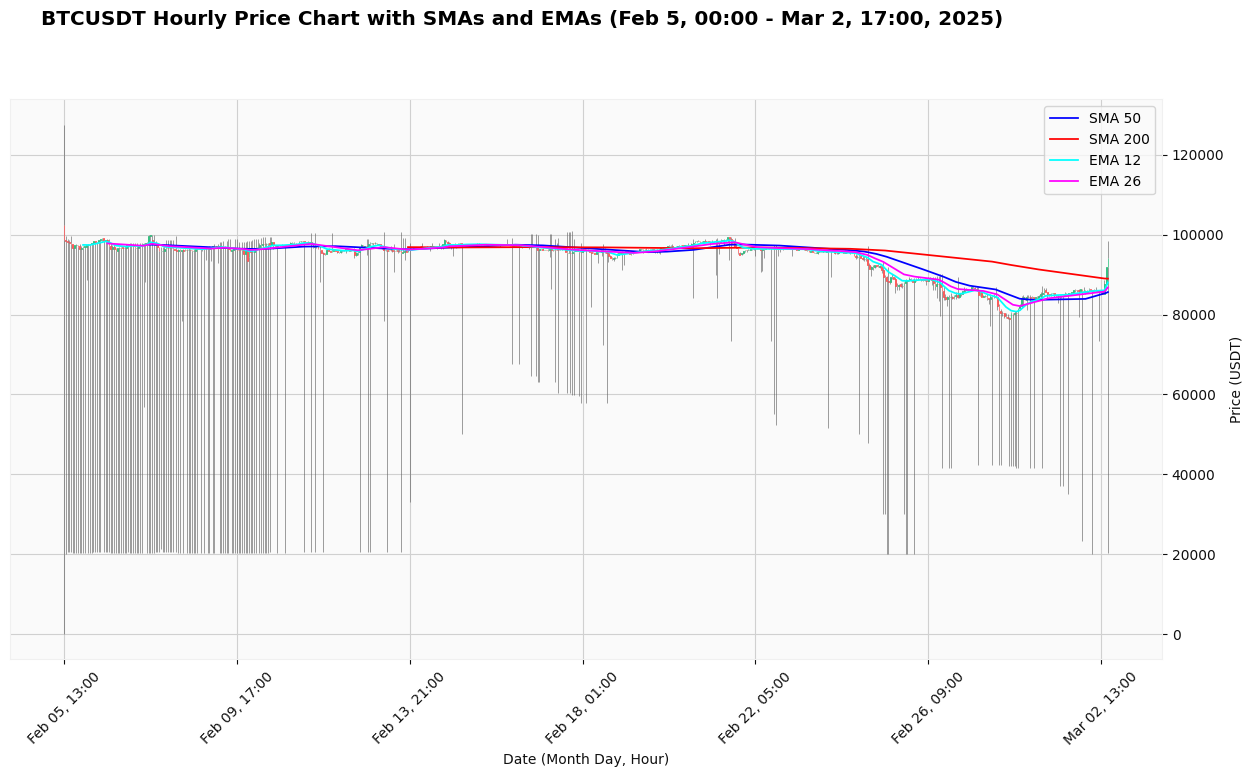

In [ ]:
# Define addplot objects for SMAs and EMAs
maPlot = [
  mpf.make_addplot(df['SMA50'], color='blue', label='SMA 50'),
  mpf.make_addplot(df['SMA200'], color='red', label='SMA 200'),
  mpf.make_addplot(df['EMA12'], color='cyan', label='EMA 12'),
  mpf.make_addplot(df['EMA26'], color='magenta', label='EMA 26')
]

# Plot candlestick with SMAs and EMAs
mpf.plot(df, type='candle', style='yahoo', figsize=(16, 8), warn_too_much_data=100000,
         title='BTCUSDT Hourly Price Chart with SMAs and EMAs (Feb 5, 00:00 - Mar 2, 17:00, 2025)',
         xlabel='Date (Month Day, Hour)', ylabel='Price (USDT)',
         addplot=maPlot
         )

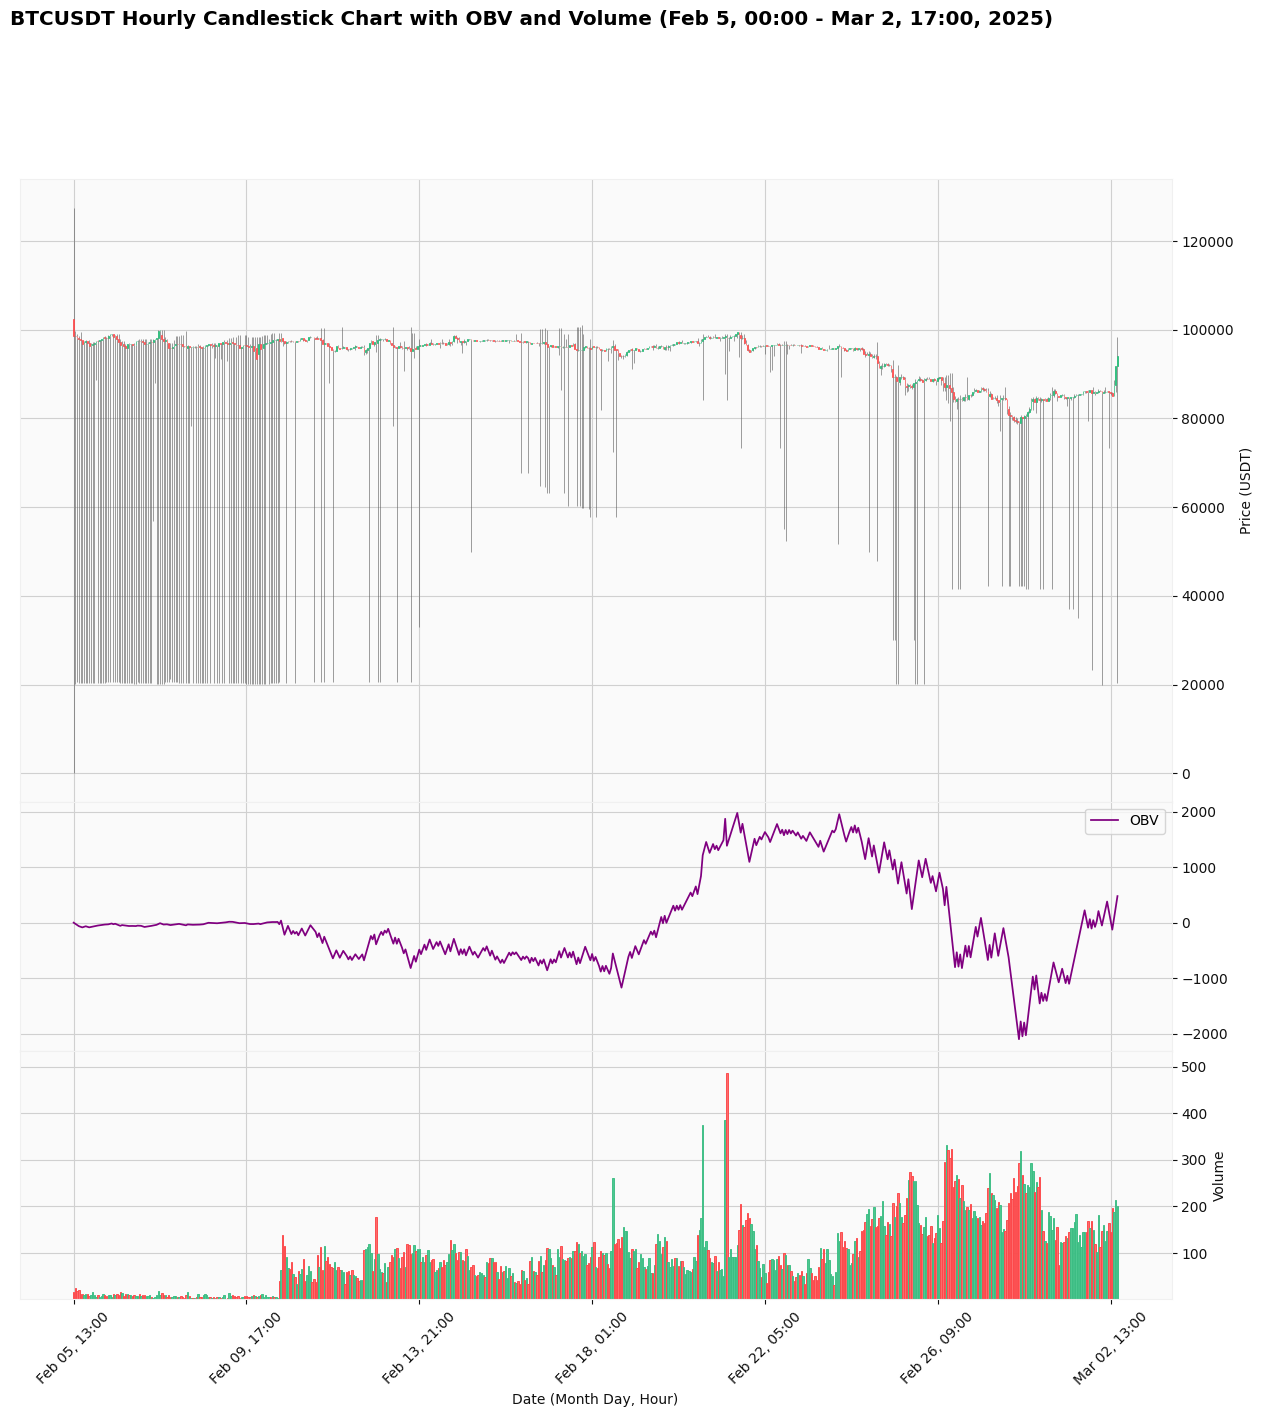

In [ ]:
# Create OBV as a separate panel (line plot)
obvPlot = mpf.make_addplot(df['OBV'], panel = 1, color = 'purple', secondary_y = False, label = 'OBV')

# Plot candlestick with OBV and volume, using custom panel backgrounds
mpf.plot(df, type='candle', style='yahoo', figsize=(16, 16), warn_too_much_data=100000,
         title='BTCUSDT Hourly Candlestick Chart with OBV and Volume (Feb 5, 00:00 - Mar 2, 17:00, 2025)',
         xlabel='Date (Month Day, Hour)', ylabel='Price (USDT)',
         addplot=obvPlot,
         volume=True, volume_panel=2)

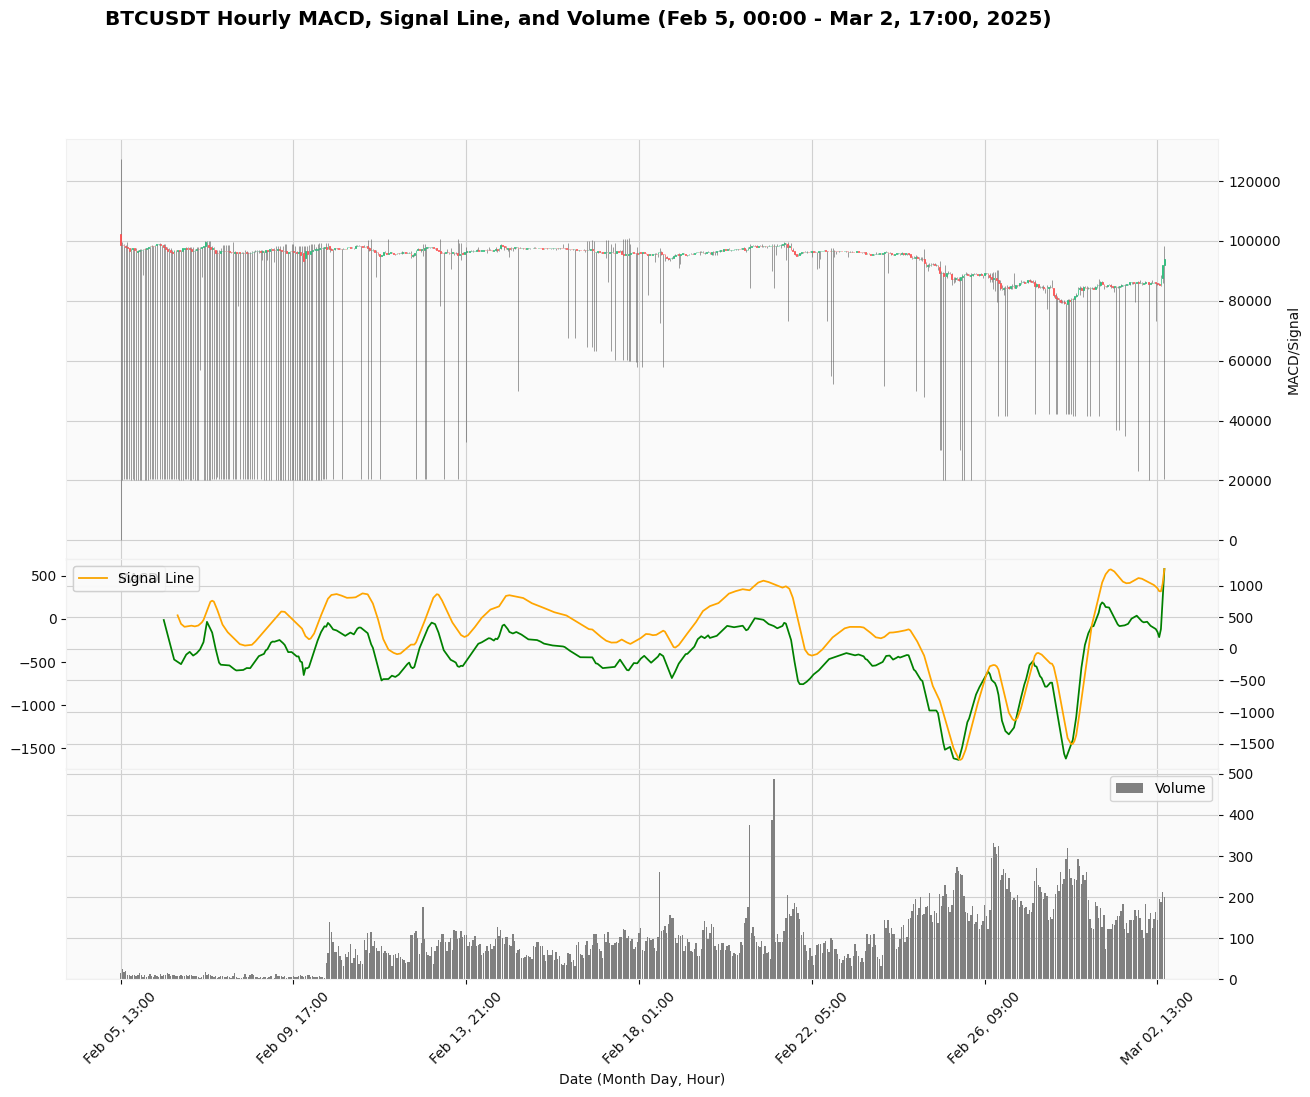

In [ ]:
# Define addplot objects for MACD, Signal Line, and Volume
macdPlot = mpf.make_addplot(df['MACD'], panel=1, color='green', label='MACD')
signalPlot = mpf.make_addplot(df['Signal_Line'], panel=1, color='orange', label='Signal Line')
volumePlot = mpf.make_addplot(df['Volume'], panel=2, type='bar', color='gray', label='Volume', secondary_y=False)

# Plot MACD, Signal Line, and Volume in a separate chart with two panels
mpf.plot(df, type='candlestick', style='yahoo', figsize=(16, 12), warn_too_much_data=100000,
         title='BTCUSDT Hourly MACD, Signal Line, and Volume (Feb 5, 00:00 - Mar 2, 17:00, 2025)',
         xlabel='Date (Month Day, Hour)', ylabel='MACD/Signal',
         addplot=[macdPlot, signalPlot, volumePlot],
         panel_ratios=(2, 1))  # Adjust panel heights (MACD/Signal:Volume = 2:1)